In [1]:
import os
import sys
import pandas as pd
import csv
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [27]:
from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import Normalizer
import xgboost as xgb
from xgboost import plot_importance

In [3]:
from matplotlib import pyplot
%matplotlib inline

In [4]:
data_folder = '../data'
data_files = os.listdir(data_folder)

In [5]:
year_2014 = pd.read_csv(data_folder+'/'+data_files[0])
year_2014.head()

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,...,Wind Direction Units,Wind Speed,Snow Depth Units,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Version
0,SUNY,22306,-,-,India,24.65,73.75,5.5,0,5.5,...,Degrees,m/s,m,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,unknown
1,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,0,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,1,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,2,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
new_columns = year_2014.iloc[1]
year_all = year_2014[2:]
year_all.columns =new_columns
year = year_all.loc[:, year_all.columns.notnull()]

# for counter,i in enumerate(new_columns):
#     print(i)


year = year.drop(columns=['Year','Month','Day','Minute','DHI','DNI','Clearsky DHI','Clearsky DNI','Fill Flag','Dew Point','Clearsky GHI','Solar Zenith Angle','Wind Direction','Snow Depth','Precipitable Water'])

In [7]:
year = year.astype('float64')
year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 2 to 8761
Data columns (total 6 columns):
Hour                 8760 non-null float64
GHI                  8760 non-null float64
Temperature          8760 non-null float64
Pressure             8760 non-null float64
Relative Humidity    8760 non-null float64
Wind Speed           8760 non-null float64
dtypes: float64(6)
memory usage: 410.7 KB


In [8]:
X = year.drop(columns=['GHI'])
Y = year.pop('GHI')

transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)


print(transformer)
print(X_norm)

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBRegressor()

Normalizer(copy=True, norm='l2')
[[0.         0.01328535 0.99804736 0.06085759 0.00461639]
 [0.00104144 0.0127023  0.99744886 0.07008445 0.00463795]
 [0.0020818  0.01228901 0.997055   0.07553548 0.00451282]
 ...
 [0.02189238 0.01564988 0.99889576 0.03825496 0.00443074]
 [0.02293431 0.01486344 0.99867655 0.04333415 0.00451597]
 [0.02396545 0.01406343 0.99830212 0.05098941 0.00456342]]


In [9]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [10]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train,verbose=True)

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot

Best: -5451.800177 using {'learning_rate': 0.2}
-153289.297746 (86998.884893) with: {'learning_rate': 0.0001}
-131936.229652 (74875.476845) with: {'learning_rate': 0.001}
-33383.736877 (18911.020543) with: {'learning_rate': 0.01}
-5570.953067 (3244.831898) with: {'learning_rate': 0.1}
-5451.800177 (3143.821412) with: {'learning_rate': 0.2}
-5541.556178 (3142.939617) with: {'learning_rate': 0.3}


In [12]:
n_estimators = [10, 20 , 50, 100, 150, 200]
max_depth = [2, 4, 6, 8, 10]
learning_rate = [0.2]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold,verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.7s finished
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future versio

Index(['Hour', 'Temperature', 'Pressure', 'Relative Humidity', 'Wind Speed'], dtype='object', name=1)
[0.52172345 0.3928043  0.01902634 0.05903273 0.00741327]


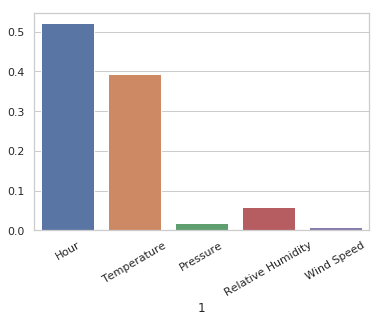

In [13]:
sns.set(style="whitegrid")
print(X.columns)
print(grid_result.best_estimator_.feature_importances_)


sns_plot = sns.barplot(X.columns,grid_result.best_estimator_.feature_importances_)
sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=30)
fig = sns_plot.get_figure()
fig.savefig("../docs/feature_importance_vertical.png",dpi=200,bbox_inches = "tight")

# sns_plot = sns.barplot(grid_result.best_estimator_.feature_importances_, X.columns)
# fig = sns_plot.get_figure()
# fig.savefig("../docs/feature_importance_horizontal.png",dpi=200,bbox_inches = "tight")

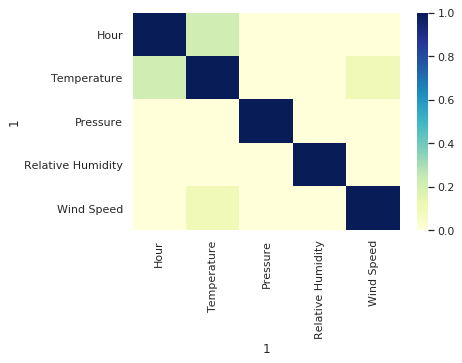

In [14]:
corr_hm = sns.heatmap(X.corr(), 
                xticklabels=X.corr().columns,
                yticklabels=X.corr().columns,vmin=0,vmax=1,cmap="YlGnBu")
plt.show()
# plt.tight_layout()

corr_hm.figure.savefig("../docs/corr_heatmap.png",dpi=200,bbox_inches = "tight")

In [15]:
print("--------------------------------------------------------------------")
print("Best: %f using %s" % (math.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("--------------------------------------------------------------------")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (math.sqrt(-mean), stdev, param))
scores = [math.sqrt(-x) for x in grid_result.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(len(max_depth), len(n_estimators))
%matplotlib notebook
%matplotlib notebook
score = {}
for ind, i in enumerate(max_depth):
    score[i] = scores[ind]

--------------------------------------------------------------------
Best: 69.701661 using {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 20}
--------------------------------------------------------------------
123.202925 (7393.884103) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 10}
86.318290 (3805.029673) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 20}
78.539076 (3427.676185) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
76.722107 (3256.354318) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
75.916877 (3181.870558) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
75.513121 (3144.135219) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
93.334501 (4956.062973) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10}
75.290810 (3287.555886) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20}
71.812246 (3043.967425) with: {'learning_rate': 0.2, 'max_depth':

In [45]:
clf = XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=20)
scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=kfold, scoring='neg_mean_squared_error')

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/pyth

RSME: 58.07 (+/- 2908.32) 


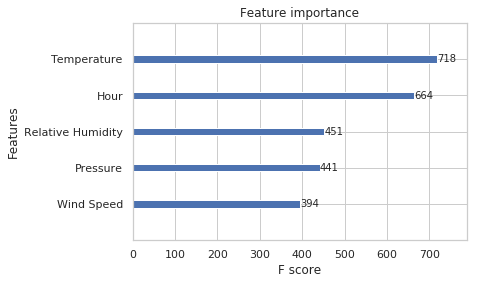

In [47]:
print("RSME: %0.2f (+/- %0.2f) " % (math.sqrt(-scores.mean()), scores.std()))
clf.fit(X_train,y_train)
plot_importance(clf)
pyplot.show()

[0.52172345 0.3928043  0.01902634 0.05903273 0.00741327]


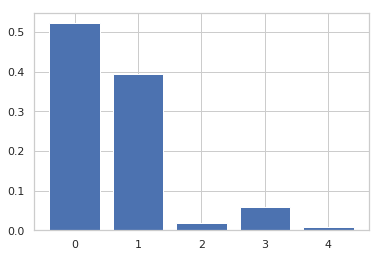

In [42]:
print(clf.feature_importances_)
%matplotlib inline
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

In [17]:
n_estimators = [20]
max_depth = [8]
learning_rate = [0.2]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train,verbose=True)

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [43]:
predictinos = clf.predict(X_test)

In [44]:
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print(math.sqrt(squared_sum/len(y_test)))   

69.23459807483844


In [20]:
import numpy as np
from bokeh.models import Label
from bokeh.layouts import gridplot
from bokeh.plotting import figure, save, output_file

p1 = figure()
p1.grid.grid_line_alpha=0.6
p1.xaxis.axis_label = 'n_estimators'
p1.yaxis.axis_label = 'RSME'

p1.line(n_estimators, score[2] , color='#A6CEE3', legend="max_depth:2")
p1.circle(n_estimators, score[2], color='#A6CEE3', legend="max_depth:2")
p1.line(n_estimators, score[4] , color='#000000', legend="max_depth:4")
p1.circle(n_estimators, score[4], color='#000000', legend="max_depth:4")
p1.line(n_estimators, score[6] , color='#FFFF00', legend="max_depth:6")
p1.circle(n_estimators, score[6], color='#FFFF00', legend="max_depth:6")
p1.line(n_estimators, score[8] , color='#00FF00', legend="max_depth:8")
p1.circle(n_estimators, score[8], color='#00FF00', legend="max_depth:8")
p1.line(n_estimators, score[10] , color='#000080', legend="max_depth:10")
p1.circle(n_estimators, score[10], color='#000080', legend="max_depth:10")

output_file("rsme.html", title="RSME Plots")

save(gridplot([[p1]], plot_width=900, plot_height=600))  # open a browser

'/home/primus/durgeshapi/ensemble/src/rsme.html'